# Demonstrations of Orbit_Cheby Functionality

 - This notebook contains a mixture of demos of finished code, as well as WIP experimentation with ways to speed-up the code 

In [ ]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import os
import sys
from collections import Counter
import glob 
import warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------

# Can't get the damn thing to work from symbolic link in ...
# '/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/orbit_cheby/__init__.py'
# So just hardpasting local link for now 
os.chdir('/Users/matthewjohnpayne/Envs/orbit_cheby/orbit_cheby')

import nbody_reader
import orbit_cheby
orbit_cheby.__file__

## Demonstrate some aspects of the main orbit_cheby routines 
 - Here I am assuming that the "nbody_reader" routine (described in "Demonstrate_NBody_Reader_Functionality.ipynb") is available to read input data, and that we can now use the main, higher-level "orbit_cheby" routines to operate on that input nbody data, and use it to generate sets of chebyshev coefficients
 - The chebyshev coefficients are fit to "sectors" of data (e.g. 32-day chunks) and saved into suitable data structures 
 - I experiment with dictionaries, but find that numpy arrays are better/faster (surprise surprise)

##### Declare an MSC (multi sector cheby) class object

In [2]:
importlib.reload(orbit_cheby)
M = orbit_cheby.MSC()

print(type(M) )
for item in dir(M) : print(item)
del M 

<class 'orbit_cheby.MSC'>
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
evaluate_components
from_coord_arrays
generate_HP
generate_RaDec
generate_UnitVector
generate_XYZ
generate_cheb_for_sector
get_valid_range_of_dates
map_JD_to_sector_number_and_sector_start_JD
map_times_to_sectors
maxerr
maxorder
minorder
sector_coeffs


##### Declare an MSC_Loader class object

In [3]:
importlib.reload(orbit_cheby)
M = orbit_cheby.MSC_Loader()

print(type(M) )
for item in dir(M) : print(item)
del M 

INIT MSC_Loader...
Defaulting to the production of a list of empty MSCs
<class 'orbit_cheby.MSC_Loader'>
FORCE_DATES
FROM_ARRAY
FROM_DATABASE
FROM_FILE
MSCs
TDB_final
TDB_init
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
_generate_empty
_populate_from_database
_populate_from_nbody_array
_populate_from_nbody_text
filepath
statearray
times_TDB
unpacked_provisional_designations


#### *Create* multi-sector chebyshev dictionary:  Txt/Numpy version 
 - This *WIP* version of the routine to do the *FUNDAMENTALLY IMPORTANT* task of converting nbody output into structured sets of chebshev coefficients uses a text-file/numpy-array based approach
 - This runs far more quickly (~1sec) than does the above json/dictoinary version 
 - My working assumption is that a ~1sec wait time is borderline tolerable for on-the-fly processing in an s9m/sifter routine (less important for mpchecker-processes, as the creation of the cheby's could be back-grounded in that scenario) 

#### Directly from array 
 - In practice, we will (hopefully) have the data in a numpy-array anyway, direct from the nbody sim
 - So here we prepopulate an array, and then demo reading in directly from the array

In [5]:
%%time 

# Pre-populate numpy array ...
text_filepath = '/Users/matthewjohnpayne/Envs/orbit_cheby/dev_data/2022AA_demo.txt'
name, times, states  = nbody_reader.parse_nbody_txt( text_filepath )


CPU times: user 594 ms, sys: 21.7 ms, total: 616 ms
Wall time: 612 ms


In [6]:
%%time 
importlib.reload(orbit_cheby)

# Use MSC_Loader to initialize & return MSC
# N.B.(1) : Loads directly from array 
# N.B.(2) : Creates a list (of length 1 in this case of MSC objects
# N.B.(3) : Use ".MSCs" to access the list of .MSCs
# N.B.(4) : Plural !! : unpacked_provisional_designations 
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs
print( 'Returned variable is of type %r , and length %r  ' % (type(MSCs),len(MSCs) ) )
M = MSCs[0]
print( 'Entry in list is of type', type(M) )
print ( 'Number of sectors = ' , len(M.sector_coeffs) )
print ( 'Shape of sector[0] = ' , M.sector_coeffs[0].shape )
del M 


INIT MSC_Loader...
Returned variable is of type <class 'list'> , and length 1  
Entry in list is of type <class 'orbit_cheby.MSC'>
Number of sectors =  623
Shape of sector[0] =  (18, 27)
CPU times: user 387 ms, sys: 5.99 ms, total: 393 ms
Wall time: 393 ms


#### Directly from array for **MULTIPLE PARTICLES**
 - Want 3D array 
 - Will create this here by sticking together a few copies of the data for a single particle ...


In [7]:
%%time 
importlib.reload(orbit_cheby)

# Pre-populate numpy array ...
# - Note that (i) we need to allow for MULTIPLE NAMES
# - We are creating a 3D array of input coords
arrays, names = [],[] 
for i in range(1,5):
    name, times, states  = nbody_reader.parse_nbody_txt( text_filepath )
    names.append(name+"_"+str(i))
    arrays.append(states)
states_3D = np.stack(arrays, axis=2)
states_3D.shape


CPU times: user 2.26 s, sys: 65.1 ms, total: 2.33 s
Wall time: 2.32 s


(20000, 27, 4)

In [8]:
%%time 
importlib.reload(orbit_cheby)

# Use MSC_Loader to initialize & return MSC
# N.B.(1) : Loads directly from array 
# N.B.(2) : Creates a list (of length 4 in this case of MSC objects
# N.B.(3) : Use ".MSCs" to access the list of .MSCs
# N.B.(4) : Plural !! : unpacked_provisional_designations 
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = names, 
                            times_TDB = times, 
                            statearray = states_3D).MSCs
print( 'Returned variable is of type %r , and length %r  ' % (type(MSCs),len(MSCs) ) )
M = MSCs[0]
print( 'Entry [0] list is of type', type(M) )
print ( 'Number of sectors = ' , len(M.sector_coeffs) )
print ( 'Shape of sector[0] = ' , M.sector_coeffs[0].shape )
del M 


INIT MSC_Loader...
Returned variable is of type <class 'list'> , and length 4  
Entry [0] list is of type <class 'orbit_cheby.MSC'>
Number of sectors =  623
Shape of sector[0] =  (18, 27)
CPU times: user 1.37 s, sys: 10.7 ms, total: 1.39 s
Wall time: 1.38 s


## Evaluate cheby's at some times ...
 - Evaluating the cheby's will be done to allow precise positional calculations, in both the sifter- and mpchecker-scenarios. 
 - In the end this needs to be a rapid evaluation ...

# XYZ positions 
 - Here we are using a relatively low-level function (generate_XYZ) to find heliocentric XYZ positions using the stored data
 - It seems to be able to perform ~1e6 XYZ calculations per second (for a single object's chebyshev coeffs, where there are 27 sets of coefficients )
 - I assume that this will vary as the number of sectors changes 

#### XYZ positions : Single Particle 


In [9]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs
M = MSCs[0]


INIT MSC_Loader...


Final XYZs.shape =  (3, 1000000)
CPU times: user 1.45 s, sys: 326 ms, total: 1.77 s
Wall time: 1.77 s


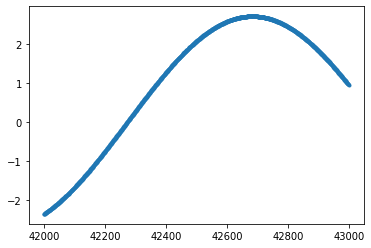

In [10]:
%%time 
importlib.reload(orbit_cheby)

nSample = int(1e6) 

# Set up some evaluation times 
evaluation_times = np.sort(42000. + 999.*np.random.rand(nSample) )

# ******************   Low-level call to get XYZ ******************
XYZs = M.generate_XYZ( evaluation_times )

# N.B. final shape = (3,len(times_TDB))
print('Final XYZs.shape = ', XYZs.shape)

# Plot x == XYZs[0] against time ... 
every=1000
plt.plot( evaluation_times[::every] , XYZs[0][::every] , '.' ) 

#### XYZ positions  :  Multiple objects 
 - N.B. in the call to *generate_XYZ* 2-cells down, we are evaluating ~1e6 * 4 position calls

In [11]:
%%time 
importlib.reload(orbit_cheby)

# Repeat the proceedure a few cells above to generate a list of MSCs
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = names, 
                            times_TDB = times, 
                            statearray = states_3D).MSCs

INIT MSC_Loader...
CPU times: user 1.5 s, sys: 8.85 ms, total: 1.51 s
Wall time: 1.5 s


CPU times: user 5.33 s, sys: 1.23 s, total: 6.55 s
Wall time: 6.56 s


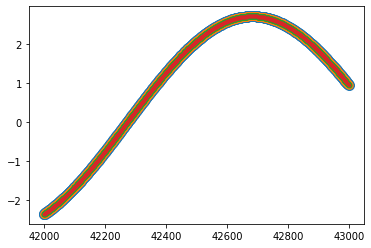

In [14]:
%%time 

nSample = int(1e6) 

# Set up some evaluation times 
evaluation_times = np.sort(42000. + 999.*np.random.rand(nSample) )

# Loop over each MSC ... 
for i, M in enumerate(MSCs): 
    
    # ******************   Low-level call to get XYZ ******************
    XYZs = M.generate_XYZ( evaluation_times )

    # Plot x == XYZs[0] against time ... 
    #every=10000

    plt.plot( evaluation_times[::every] , XYZs[0][::every] , '.' , ms = 20-5*i) 

# Observational UnitVector Calculations

###### SIFTER: This UV calc is used at the time of query to (a) get the approx HP (see below) and (b) to get refined positions for precise tracklet matching 
###### MPCHECKER: This UV calc is used at the time of query to get refined positions for any approx matches extracted from the precalculated data

 - These calculations require that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to generate a set of standardized input observatory-positions (using a silly ~circular approximation) and then provide those as inputs. 
     

In [23]:
%%time 
importlib.reload(orbit_cheby)

# Create a sample of observatory-positions as inputs 
# - Note that the NBody code uses BARYCENTRIC EQUATORIAL coords
# - So the Cheby's need to work-in/evaluate-to equatorial coords
# - Hence the observatory-positions will need to be in equatorial coords
nSample = int(1e3) 
evaluation_times = np.sort(42000. + 999.*np.random.rand(nSample) )
r = 1.0 
XYZobservatory_equatorial = np.array( [r*np.cos(evaluation_times), 
                                        r*np.sin(evaluation_times) , 
                                        0.0001*r*np.cos(evaluation_times)])

CPU times: user 4 ms, sys: 5.76 ms, total: 9.76 ms
Wall time: 11.2 ms


#### Unit-Vector : Single Particle 

In [24]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...


 - In this initial experiment *BELOW* I find that it takes: 
        ~1s to evaluate 1e6 unit vectors for a single object using an APPROX (non-iterated) approach
        ~3s to evaluate 1e6 unit vectors for a single object using a NON-APPROX (iterated) approach 
 

In [25]:
%%time 

# Now evaluate some unit vectors [[APPROXIMATE calculation]]
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
UVs = M.generate_UnitVector(  evaluation_times , 
                            XYZobservatory_equatorial, 
                            APPROX = True)

# N.B. final shape = (3,len(times_TDB))
UVs.shape 

CPU times: user 9.46 ms, sys: 4.12 ms, total: 13.6 ms
Wall time: 11.5 ms


(3, 1000)

In [26]:
%%time 

# Now evaluate some unit vectors [[EXACT Calculation]]
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
UVs = M.generate_UnitVector( evaluation_times , 
                                    XYZobservatory_equatorial, 
                                    APPROX = False
                                              )
# N.B. final shape = (3,len(times_TDB))
print(UVs.shape)


(3, 1000)
CPU times: user 25.4 ms, sys: 3.15 ms, total: 28.6 ms
Wall time: 25.6 ms


#### Unit-Vector : Multi Particle 

In [27]:
%%time 
importlib.reload(orbit_cheby)

# Repeat the proceedure a few cells above to generate a list of MSCs
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = names, 
                            times_TDB = times, 
                            statearray = states_3D).MSCs

INIT MSC_Loader...
CPU times: user 1.44 s, sys: 7.04 ms, total: 1.45 s
Wall time: 1.45 s


In [28]:
%%time 

# Loop over each MSC ... 
for i, M in enumerate(MSCs): 
    
    UVs = M.generate_UnitVector( evaluation_times , 
                                    XYZobservatory_equatorial, 
                                    APPROX = False)
    print(UVs.shape)

(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
CPU times: user 97.8 ms, sys: 3.71 ms, total: 102 ms
Wall time: 99.2 ms


### Observational HP Calculations
###### SIFTER: This HP routine will be used intensively at the time a search is executed to find the APPROX HP location of an object over a series of many nights 
###### MPCHECKER: This HP routine will be used in the precalculation phase to find-and-store the HP location of an object across a series of nights 


 - Because this is a wrapper around the unitvector call, the hp call again requires that the positions of the observatory are provided as inputs: I.e. I want to completely separate the obs-posn stuff from the cheby evaluation calculations
 - For the sake of these demonstrations, I am going to use the obs-posns generated above
 
This brief experiment finds that the time to calcuate 1e6 healpix is essentially the same as the time to  generate the underlying 1e6 unitvectors

#### HP : Single Particle 

In [34]:
importlib.reload(orbit_cheby)

# Repeat the above to generate an MSC populated from above array ... 
M = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = name, 
                            times_TDB = times, 
                            statearray = states).MSCs[0]

INIT MSC_Loader...


In [35]:
%%time 
importlib.reload(orbit_cheby)
# Now evaluate the HP vectors  
# - With these kinds of input, all I am really doing is ascertaining that the functions work in the sense of producing numbers
# - There is no real understanding of whether the numbers are accurate / correct 
HPs= M.generate_HP( evaluation_times , 
                XYZobservatory_equatorial, 
                APPROX = True )
# N.B. final shape = (3,len(times_TDB))
HPs.shape , evaluation_times.shape


internal UVshaoe =  (3, 1000)
CPU times: user 11.4 ms, sys: 2.33 ms, total: 13.8 ms
Wall time: 11.7 ms


((1000,), (1000,))

#### HP : Multi Particle 

In [39]:
%%time 
importlib.reload(orbit_cheby)

# Repeat the proceedure a few cells above to generate a list of MSCs
MSCs = orbit_cheby.MSC_Loader(FROM_ARRAY = True , 
                            unpacked_provisional_designations = names, 
                            times_TDB = times, 
                            statearray = states_3D).MSCs

INIT MSC_Loader...
CPU times: user 1.41 s, sys: 6.97 ms, total: 1.41 s
Wall time: 1.41 s


In [40]:
%%time 

# Loop over each MSC ... 
for i, M in enumerate(MSCs): 
    
    HPs = M.generate_HP( evaluation_times , 
                        XYZobservatory_equatorial, 
                        APPROX = True)
    print(HPs.shape)

(1000,)
(1000,)
(1000,)
(1000,)
CPU times: user 39.8 ms, sys: 3.72 ms, total: 43.5 ms
Wall time: 40.4 ms
